# Introduction

In this notebook we show the inference on COVID-19 data done for the article https://arxiv.org/abs/2010.03097. Which has been also used as one of the analysis that supports the reports made HERE by some members of the DATA LAb of University of Guanajuato.

This notebook is read only, but you'll be able to execute it by accesing through a google account. However, in order to save the data and your changes you need to create a copy.

Authors: Alma X. González Morales and Luis Ureña López.

Questions can be sent to alma.gonzalez@fisica.ugto.mx and lurena@fisica.ugto.mx

# Setting up the notebook

## Install Libaries if needed

This section is only for running on Google Collaboratory, if you are running
this notebook in a local machine, make sure of install the necesary libraries before, and comment the following couple of cells.

In [ ]:
!pip install corner

In [ ]:
!pip install emcee

## Load Libraries

In [ ]:
#Load most of the libraries to use.
import sys
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import corner
import emcee
import time
from datetime import datetime,timedelta
from pathlib import Path
import multiprocessing
from multiprocessing import Pool,cpu_count
np.random.seed(0) #Lets set a seed for the random number generator to have reproduceble results.


## Define some functions to be used.

In [ ]:

# Model of a logistic curve, exact solution of the SI epidemic model
def uvar(x,x0,k0,k1):
    a = 1.e-1
    uvar = k0*(1.-np.exp(-a*k1*(x-x0)))/a
    return uvar

def model(x, L, x0, k0, k1):
    u = uvar(x,x0,k0,k1)
    fx = L*np.exp(u)
    return fx

def modelinf(L, k0):
    a = 1.e-1
    fxinf = L*np.exp(k0/a)
    return fxinf

# Derivative of the logistic curve
def modelDeriv(x, L, x0, k0, k1):
    a = 1.e-1
    u = uvar(x,x0,k0,k1)
    dfx = L*np.exp(u)*modelbeta(x-x0,k0,k1)
    return dfx

#beta model
def modelbeta(x,k0,k1):
    a = 1.e-1
    beta = k0*k1*np.exp(-a*k1*x)
    return beta

#Poisson distribution for deaths. There is a delay factor of x0d with respect to confirmed positives
def loglike_PoissD(theta,ndead,nmin=0):
    L,Ld,x0,k0,k1 = theta
    xx=np.arange(0,len(ndead))
    y=ndead[ndead>nmin]
    xx=xx[ndead>nmin]
    y0=model(xx,Ld,x0,k0,k1)
    w=y<40
    logyfact=np.zeros(len(y))
    if w.any is True:
        logyfact[w]=np.log(np.factorial[y[w]])
        logyfact[~w]=y[~w]*np.log(y[~w])-y[~w]
    else:
        logyfact=y*np.log(y)-y
    s=np.sum(-y0+y*np.log(y0)-logyfact)
    if np.isnan(s):
        return 0.
    return s

#Poisson distribution for confirmed positives
def loglike_PoissPos(theta,npos,nmin=0):
    L,Ld,x0,k0,k1 = theta
    xx=np.arange(0,len(npos))
    y=npos[npos>nmin]
    xx=xx[npos>nmin]
    y0=model(xx,L,0.,k0,k1)
    w=y<40
    logyfact=np.zeros(len(y))
    if w.any is True:
        logyfact[w]=np.log(np.factorial[y[w]])
        logyfact[~w]=y[~w]*np.log(y[~w])-y[~w]
    else:
        logyfact=y*np.log(y)-y
    s=np.sum(-y0+y*np.log(y0)-logyfact)
    if np.isnan(s):
        return 0.
    return s

# Flat prior. Lmax is suggested by the normalization used of the positive data
# Ld < 1 as the number of deaths should be lower than that of confirmed positives
# x0 and x0d < 100, as expected that the inflection point is no far away from the date of first death
# k= r \beta in the SIS model, and then it should be smaller than 1.
# The units of k are [1/days], actually the period of duplication is t=ln 2/k
def lnprior_(theta):
    L,Ld,x0,k0,k1= theta
    if 0< L < 20 and 0< Ld <100 and 0<x0< 50 and 0<k0<3 and 0<k1<3:
        return 0.          #Is for a uniform prior on the given range
    return -np.inf

def lnprob_poisson(theta,data,deadths=True):
    npos,ndead=data
    lp = lnprior_(theta)
    if not np.isfinite(lp):
        return -np.inf
    loglike=loglike_PoissPos(theta,npos)
    if deadths==True:
        loglike+=loglike_PoissD(theta,ndead)
    return lp +loglike



In [ ]:
#Select the country of interest
country_choice='Mexico'
cases='Cases'
save_plots='Yes'

#Make a directory to save the plots of the chosen country
if save_plots == 'Yes':
    save_path='./plots/'+country_choice+'B'
    Path(save_path).mkdir(parents=True, exist_ok=True)

#Mortality rate % (estimated by the WHO is 3.4%)
#https://www.worldometers.info/coronavirus/coronavirus-death-rate/
# In technical terms, here we quote the infected rate fatality.
#Using Diamond Princess estimation
death_rate = 0.4

#Time from infection to death
#This needs to be justified more firmly from evidence
#Mexico: from positive to dead is 9 days.
#Incubation period seems to be 6.4 (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7014672/)
death_delay = 16

#Inverse of the recovery parameter
gamma = 16

NameError: ignored

# Explore the Data

## Read the data and start exploring it before any fitting.

In [ ]:
#Read data directly from online repository. Notice the data used is not the latest one, but updated until Novemeber 2020.
P_data = pd.read_csv('https://covid.ourworldindata.org/data/ecdc/total_cases.csv')
D_data = pd.read_csv('https://covid.ourworldindata.org/data/ecdc/total_deaths.csv')


#Determine the first nonzero dead counting in the column country_choice
First_data = D_data[country_choice][:]
start = First_data.loc[First_data >= 1].index
start_row = start[0]
end_row = P_data[P_data['date']=='2020-10-03'].index[0]+1  #We are limiting the date to that corresponding to the date used in https://arxiv.org/abs/2010.03097.
#Note added, the data base changed after submision of the above manuscript, therefore there are some changes in the plots.

#Select a subsample of the data, for instance to match a previous date.
if end_row != None:
    Pos_data = P_data[country_choice][start_row:end_row]
    Dead_data = D_data[country_choice][start_row:end_row]
else:
    Pos_data = P_data[country_choice][start_row:]
    Dead_data = D_data[country_choice][start_row:]

P_data = P_data[start_row:end_row]
D_data = D_data[start_row:end_row]
#Make some definitions to use data as numpy arrays, and normalized.
x = np.arange(0, len(Pos_data))
nposdefault = np.asarray(Pos_data, dtype='float')
ndeaddefault = np.asarray(Dead_data, dtype='float')
npos = np.asarray(Pos_data, dtype='float')/nposdefault[0]
ndead = np.asarray(Dead_data, dtype='float')/ndeaddefault[0]

nposdiff = np.diff(npos)
npos1 = np.asarray(P_data[country_choice][1:], dtype='float')/nposdefault[0]
ndeaddiff = np.diff(ndead)
ndead1 = np.asarray(D_data[country_choice][1:], dtype='float')/ndeaddefault[0]

#Time stamp for the output figures and forecast
#Forecast at tomorrow
forecast=7
date_info=datetime.strptime((P_data['date'].tail(1)).values[0], '%Y-%m-%d') ## or use datetime.today() if you want to use today date for the forcast but it does not match with the last day in the data
date= date_info.strftime('%b%d')
tomorrow = (date_info + timedelta(days=forecast)).strftime('%b%d')

In [ ]:
P_data['date']

81     2020-03-21
82     2020-03-22
83     2020-03-23
84     2020-03-24
85     2020-03-25
          ...    
273    2020-09-29
274    2020-09-30
275    2020-10-01
276    2020-10-02
277    2020-10-03
Name: date, Length: 197, dtype: object

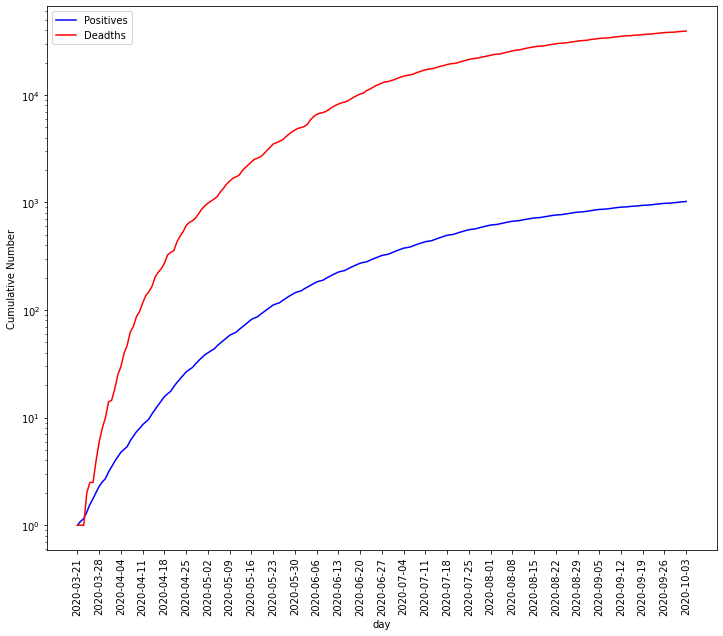

In [ ]:
N = 7  # 1 tick every 7
#Plot the data
plt.figure(figsize=(12,10))


plt.plot(P_data['date'],npos,'b',label='Positives')
plt.plot(D_data['date'],ndead,'r',label='Deadths')


plt.yscale('log')
plt.xlabel('day')
plt.ylabel('Cumulative Number')
xticks_pos, xticks_labels = plt.xticks()  # get all axis ticks
myticks = [i for i,j in enumerate(xticks_pos) if not i%N]  # index of selected ticks
plt.xticks(myticks, rotation=90)
plt.legend()

plt.savefig(save_path+"/Cases.png")


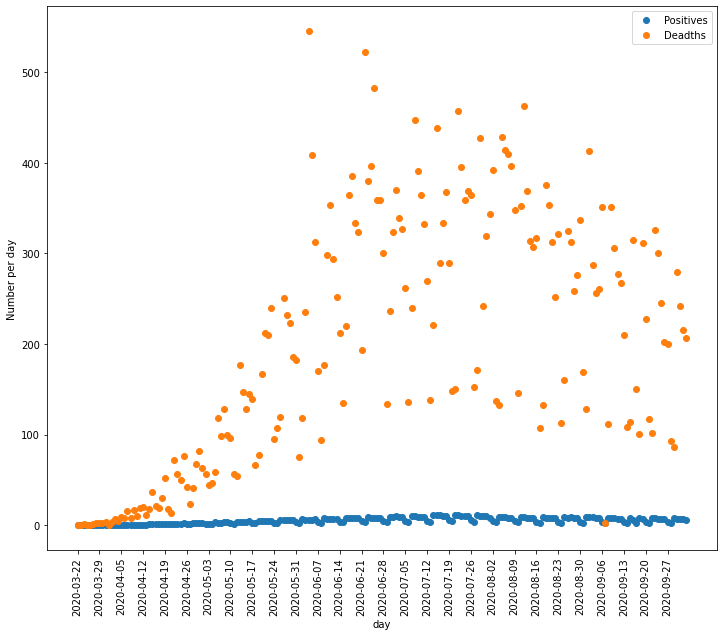

In [ ]:
#Another plot of the data
plt.figure(figsize=(12,10))
plt.plot(P_data['date'][1:],np.diff(npos),'o',label='Positives')
plt.plot(D_data['date'][1:],np.diff(ndead),'o',label='Deadths')


plt.xlabel('day')
plt.ylabel('Number per day')
xticks_pos, xticks_labels = plt.xticks()  # get all axis ticks
myticks = [i for i,j in enumerate(xticks_pos) if not i%N]  # index of selected ticks
plt.xticks(myticks, rotation=90)
plt.savefig(save_path+"/Cases.png")
plt.legend()
plt.xticks(rotation=90)
plt.legend()

## Do a first fit and compare to data.

This will serve as starting point for the MCMC

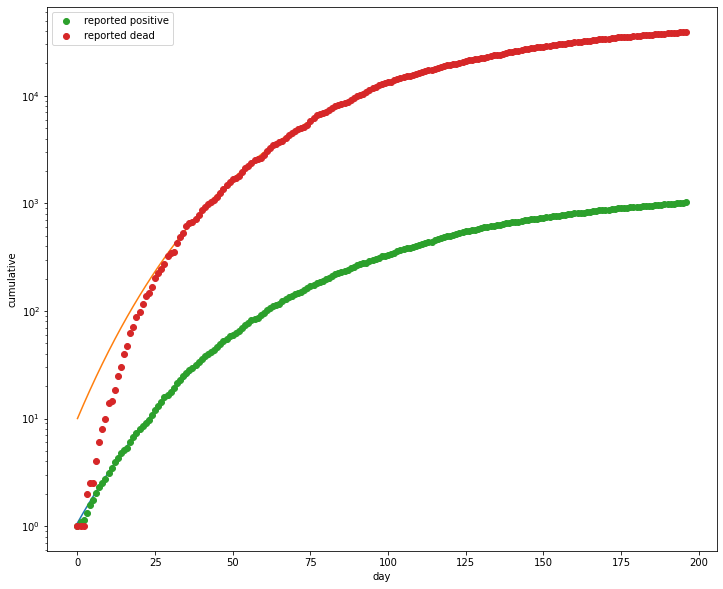

In [ ]:

#Fit exponential-beta curve
min_pos=0
min_dead=0
p_pos, p_cov = curve_fit(model, x[npos>min_pos], npos[npos>min_pos], bounds=(0,[10,10,10,10]))
p_dead, p_cov = curve_fit(model, x[ndead>min_dead], ndead[ndead>min_dead], bounds=(0,[10,10,10,10]))

plt.figure(figsize=(12,10))
plt.plot(x,model(x,p_pos[0],p_pos[1],p_pos[2],p_pos[3]))
plt.plot(x,model(x,p_dead[0],p_dead[1],p_dead[2],p_dead[3]))
plt.plot(x,npos,'o',label='reported positive')
plt.plot(x,ndead,'o',label='reported dead')
plt.yscale('log')
plt.xlabel('day')
plt.ylabel('cumulative')
plt.legend()

[ 0.38330023 15.02115608  1.40692634  0.80927734  0.18251816]


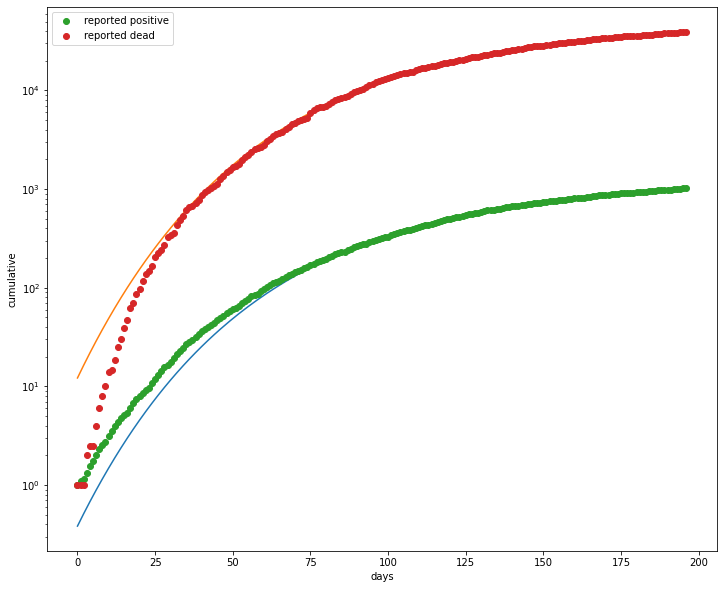

In [ ]:
#Try to fit them simultaneusly, with k0, k1 as common parameters, and including x0 as delay for deads
len1=len(npos[npos>min_pos])
len2=len(ndead[ndead>min_dead])
comboY = np.append(npos[npos>min_pos], ndead[ndead>min_dead])
comboX = np.append(x[npos>min_pos],x[ndead>min_dead])

def comboFunc(comboData, L,Ld,x0,k0,k1):
    # single data set passed in, extract separate data
    extract1 = comboData[:len1] # first data
    extract2 = comboData[len1:] # second data

    result1 = model(extract1, L, 0., k0, k1)
    result2 = model(extract2, Ld, x0, k0, k1)

    return np.append(result1, result2)

fittedParameters, pcov = curve_fit(comboFunc, comboX, comboY,  bounds=(0,[20,20,10,10,10]))

plt.figure(figsize=(12,10))
plt.plot(x,model(x,fittedParameters[0],0.,fittedParameters[3],fittedParameters[4]))
plt.plot(x,model(x,fittedParameters[1],fittedParameters[2],fittedParameters[3],fittedParameters[4]))
plt.plot(x,npos,'o',label='reported positive')
plt.plot(x,ndead,'o',label='reported dead')
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('days')
plt.ylabel('cumulative')
plt.legend()
print(fittedParameters)

# MCMC

We are ready to run the MCMC. First, check that the initial point gives a finite number when used to evaluate the likelihood. *italicized text*

In [ ]:
theta0=[fittedParameters[0],fittedParameters[1],fittedParameters[2],fittedParameters[3],fittedParameters[4]]
data=[npos,ndead]
lnprob_poisson(theta0,data)

-839.1247608487838

Now we'll run the MCMC, this might take a while and you might want to adjust the number of CPU depending on the resources available. For google collab we can use 2 cpu's

In [ ]:
nproc=multiprocessing.cpu_count() #Check number of cpu availables for the MCMC
print(nproc)

2


In [ ]:
#The chain leght and number of walkers were set to smaller than needed just for ilustrative purposes. Use something like clength=20000 and nwalkers=100 for better results
clength=2000
ndim, nwalkers = 5,20
pos=[theta0+1e-2*np.random.rand(ndim) for i in range(nwalkers)]

print ('walker initialized')

with Pool(nproc) as pool:
    sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob_poisson,pool=pool,args=[data])
    print ('running mcmc, please wait')
    start_time = time.time()
    p, lnprob_0,rstate=sampler.run_mcmc(pos,clength,progress=True)
    end_time = time.time()
    print("MCMC took {0:.1f} seconds".format(end_time-start_time))

tau = sampler.get_autocorr_time(quiet=True)
print(tau)

walker initialized


  0%|          | 0/2000 [00:00<?, ?it/s]

running mcmc, please wait


100%|██████████| 2000/2000 [00:12<00:00, 158.59it/s]
N/50 = 40;
tau: [219.23367605 226.5092367  235.31588635 230.6604269  114.06613632]


MCMC took 12.7 seconds
[219.23367605 226.5092367  235.31588635 230.6604269  114.06613632]


# MCMC analysis

The MCMC ran succesfully now lets see the result and interpret it.




In [ ]:
# We'll evaluate derived quatities from the parameters fitted in the MCMC. Such as the normalized values at infinity, the time for crossing
# As well as forecasted numbser of positives and deads.

chains_p=sampler.chain
frac=0.5 ## If you run longer chains you can increase the fraction to be discarded as burning
#Values obtained directly from the fitting to data
flat_samples = sampler.get_chain(discard=int(frac*clength), thin=15, flat=True)

flat_samples_r =[[L,Ld,x0,k0*k1,0.1*k1] for [L,Ld,x0,k0,k1] in flat_samples]

#Normalized values at infinity and time for crossings
flat_samples_ =[[modelinf(L,k0),modelinf(Ld,k0),0.1*k1*L*np.exp(10*k0-1),0.1*k1*Ld*np.exp(10*k0-1),
                 L*np.exp(10*k0-1),Ld*np.exp(10*k0-1),
                 10*np.log(2.)/k1,0.9*modelinf(L,k0),0.9*modelinf(Ld,k0)] for [L,Ld,x0,k0,k1] in flat_samples]

#Values at infinity
flat_samples_p =[[nposdefault[0]*modelinf(L,k0),ndeaddefault[0]*modelinf(Ld,k0),nposdefault[0]*L*np.exp(10*k0-1),ndeaddefault[0]*Ld*np.exp(10*k0-1),
                 k0*k1,0.1*k1,10*np.log(10*k0)/k1,x0+10*np.log(10*k0)/k1,-10.*np.log(0.1*np.log(10./9.)/k0)/k1,x0-10.*np.log(0.1*np.log(10./9.)/k0)/k1] for [L,Ld,x0,k0,k1] in flat_samples]

#Forecasted values at present+forecast
flat_samples_pred = [[model(x[-1]+forecast,nposdefault[0]*L,0.,k0,k1),model(x[-1]+forecast,ndeaddefault[0]*Ld,x0,k0,k1),
                      modelDeriv(x[-1]+forecast,nposdefault[0]*L,0.,k0,k1),
                      modelDeriv(x[-1]+forecast,ndeaddefault[0]*Ld,x0,k0,k1),
                      model(x[-1]+forecast-death_delay,1e2*ndeaddefault[0]*Ld/death_rate,x0,k0,k1)]
                     for [L,Ld,x0,k0,k1] in flat_samples]

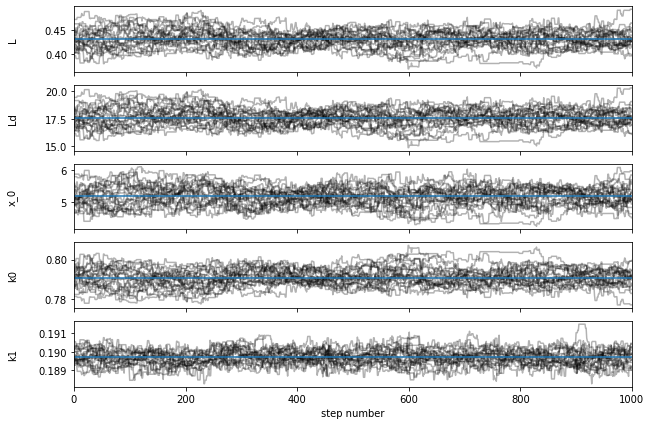

In [ ]:
# Plot the samples accepted for each of the fitted parameteres.
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
labels = ["L","Ld","x_0","k0","k1"]
burning=int(frac*clength)
for j in range(20):
    for i in range(ndim):
        ax = axes[i]
        ax.plot(chains_p[j,burning:, i], "k", alpha=0.3)
        ax.set_xlim(0, len(chains_p[j,burning:, i]))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
Lmed=np.median(chains_p[:,burning:, 0])
Ldmed=np.median(chains_p[:,burning:, 1])
x0_med=np.median(chains_p[:,burning:, 2])
k0_med=np.median(chains_p[:,burning:, 3])
k1_med=np.median(chains_p[:,burning:, 4])
axes[0].axhline(Lmed)
axes[1].axhline(Ldmed)
axes[2].axhline(x0_med)
axes[3].axhline(k0_med)
axes[4].axhline(k1_med)
axes[-1].set_xlabel("step number");

In [ ]:
#Compute percentiles
(L,Lmax,Lmin),(Ld,Ldmax,Ldmin),(x0,x0max,x0min),(k0,k0max,k0min),(k1,k1max,k1min)=map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(flat_samples,[0.5,50,99.5],  axis=0)))

#Values at t->infty
(P,Pmax,Pmin),(D,Dmax,Dmin),(PD,PDmax,PDmin),(DD,DDmax,DDmin),(Pmed,Pmedmax,Pmedmin),(Dmed,Dmedmax,Dmedmin),(tmed,tmedmax,tmedmin),(P90,P90max,P90min),(D90,D90max,D90min)=map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(flat_samples_,[0.5,50,99.5],  axis=0)))

#(Inf,Infmax,Infmin),(rdI,rdImax,rdImin),(PD,PDmax,PDmin),(DD,DDmax,DDmin)=map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(flat_samples_I,[0.5,50,99.5],  axis=0)))

#Full values of the fitting to data
(Pp,Ppmax,Ppmin),(Dp,Dpmax,Dpmin),(P0,P0max,P0min),(D0,D0max,D0min),(k0p,k0pmax,k0pmin),(k1p,k1pmax,k1pmin),(tp,tpmax,tpmin),(tdp,tdpmax,tdpmin),(t90,t90max,t90min),(tD90,tD90max,tD90min)=map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(flat_samples_p,[0.5,50,99.5],  axis=0)))

#Full values of the fitting to data
(Ptw,Ptwmax,Ptwmin),(Dtw,Dtwmax,Dtwmin),(Pdtw,Pdtwmax,Pdtwmin),(Ddtw,Ddtwmax,Ddtwmin),(Itw,Itwmax,Itwmin)=map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
zip(*np.percentile(flat_samples_pred,[0.5,50,99.5],  axis=0)))

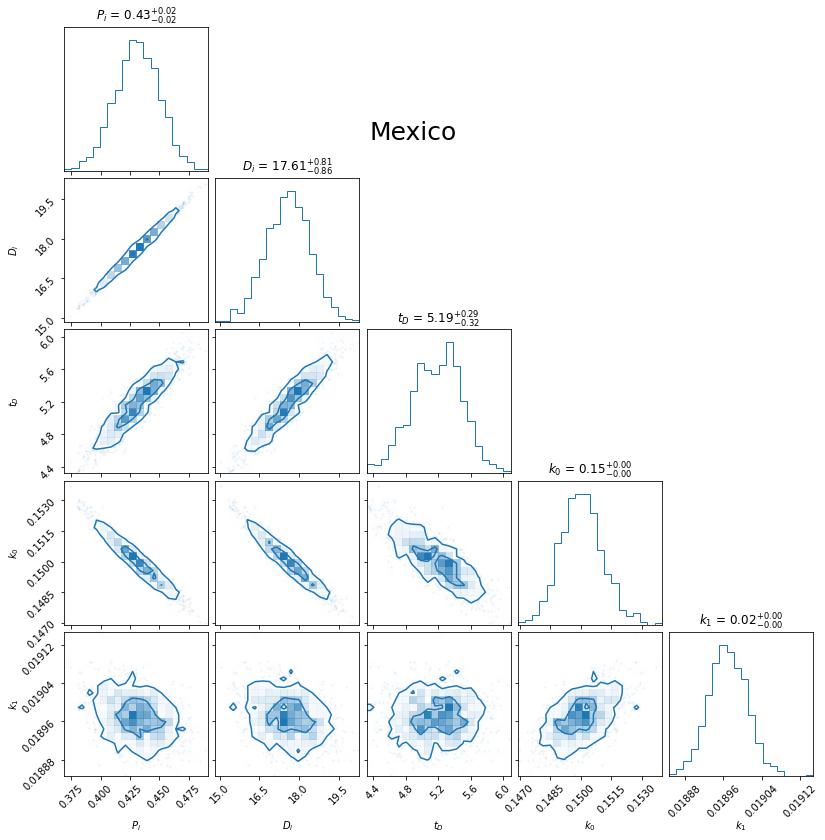

In [ ]:
#Lests do the usual corner plot for some of the parameters fitted and derived.
fig = corner.corner(flat_samples_r,levels=(1-np.exp(-0.5),1-np.exp(-2.)),show_titles=True,color='C0',
                    labels=[r"$P_i$",r"$D_i$",r"$t_D$",r"$k_0$",r"$k_1$"],fontsize=20);

plt.text(0.5, 10, country_choice , ha='left', va='top', transform=ax.transAxes,fontsize=25)

#Save the figure to disk
if save_plots == 'Yes':
    plt.savefig('plots/'+ country_choice+'B/'+ country_choice+ 'B_Triangle_TD.pdf', dpi=150)



```
# This is formatted as code
```

#Results and summary plots

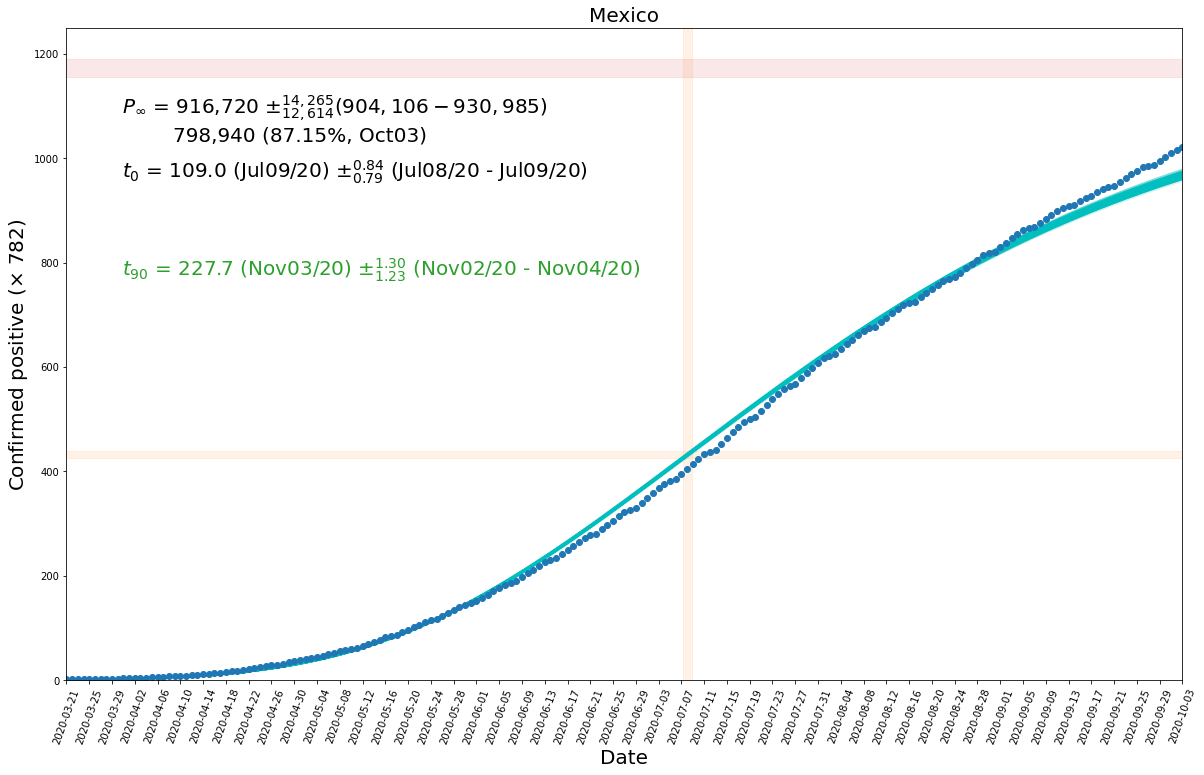

In [ ]:
# Plot of confirmed possitves, data and models as well with preduction for a future date
fig, ax = plt.subplots(figsize=(20,12))
x2 = np.arange(0, end_row+20)
for i in range(500):
    index = np.random.randint(0,len(flat_samples)-1)
    model_ = model(x2, flat_samples[index,0],0.,flat_samples[index,3],flat_samples[index,4])
    ax.plot(x2, model_, 'c', linewidth=.5, alpha=0.2)
ax.plot(P_data['date'], npos, 'o')

inflex = (date_info - timedelta(days=int(x[-1]-tp))).strftime('%b%d/%y')
inflexmin = ( date_info- timedelta(days=int(x[-1]-tp+tpmin))).strftime('%b%d/%y')
inflexmax = (date_info  - timedelta(days=int(x[-1]-tp-tpmax))).strftime('%b%d/%y')

t90ex = (date_info  + timedelta(days=int(t90-x[-1]))).strftime('%b%d/%y')
t90exmin = (date_info  + timedelta(days=int(t90-t90min-x[-1]))).strftime('%b%d/%y')
t90exmax = (date_info  + timedelta(days=int(t90+t90max-x[-1]))).strftime('%b%d/%y')


plt.title(country_choice,fontsize=20)
plt.xticks(rotation = 70)
plt.xlabel('Date',fontsize=20)
plt.ylabel(r'Confirmed positive ($\times$ %s)'%'{:,.0f}'.format(nposdefault[0]),fontsize=20)
plt.text(0.05, .90, r'$P_\infty$ = %s $\pm^{%s}_{%s} (%s - %s)$'
         %('{:,.0f}'.format(Pp),
           '{:,.0f}'.format(Ppmax),
           '{:,.0f}'.format(Ppmin),'{:,.0f}'.format(Pp-Ppmin),'{:,.0f}'.format(Pp+Ppmax)),
         ha='left', va='top', transform=ax.transAxes,fontsize=20)
plt.text(0.05, .85, '        %s (%s, %s) ' %('{:,.0f}'.format(nposdefault[-1]), '{:,.2%}'.format(nposdefault[-1]/Pp),
                                          date),ha='left', va='top', transform=ax.transAxes,fontsize=20)
plt.text(0.05, .8, r'$t_0$ = %.1f (%s) $\pm^{%.2f}_{%.2f}$ (%s - %s)' %(tp,inflex,tpmax,tpmin,inflexmin,inflexmax),ha='left', va='top',
    transform=ax.transAxes,fontsize=20)
plt.text(0.05, .65, r'$t_{90}$ = %.1f (%s) $\pm^{%.2f}_{%.2f}$ (%s - %s)' %(t90,t90ex,t90max,t90min,t90exmin,t90exmax),ha='left', va='top',
    transform=ax.transAxes,fontsize=20,color='C2')

plt.axhspan(P-Pmin,P+Pmax, alpha=0.1,color='C3')

plt.axhspan(Pmed-Pmedmin,Pmed+Pmedmax, alpha=0.1,color='C1')
plt.axvspan(tp-tpmin,tp+tpmax,alpha=0.1, color='C1')
plt.xlim((0,x[-1]))
plt.ylim((0,None))
ax.set_xticks(ax.get_xticks()[::4])


#Save the figure to disk
if save_plots == 'Yes':
    plt.savefig('plots/'+ country_choice+'B/'+ country_choice + 'B_Pos_TD.pdf', dpi=150)

plt.show()

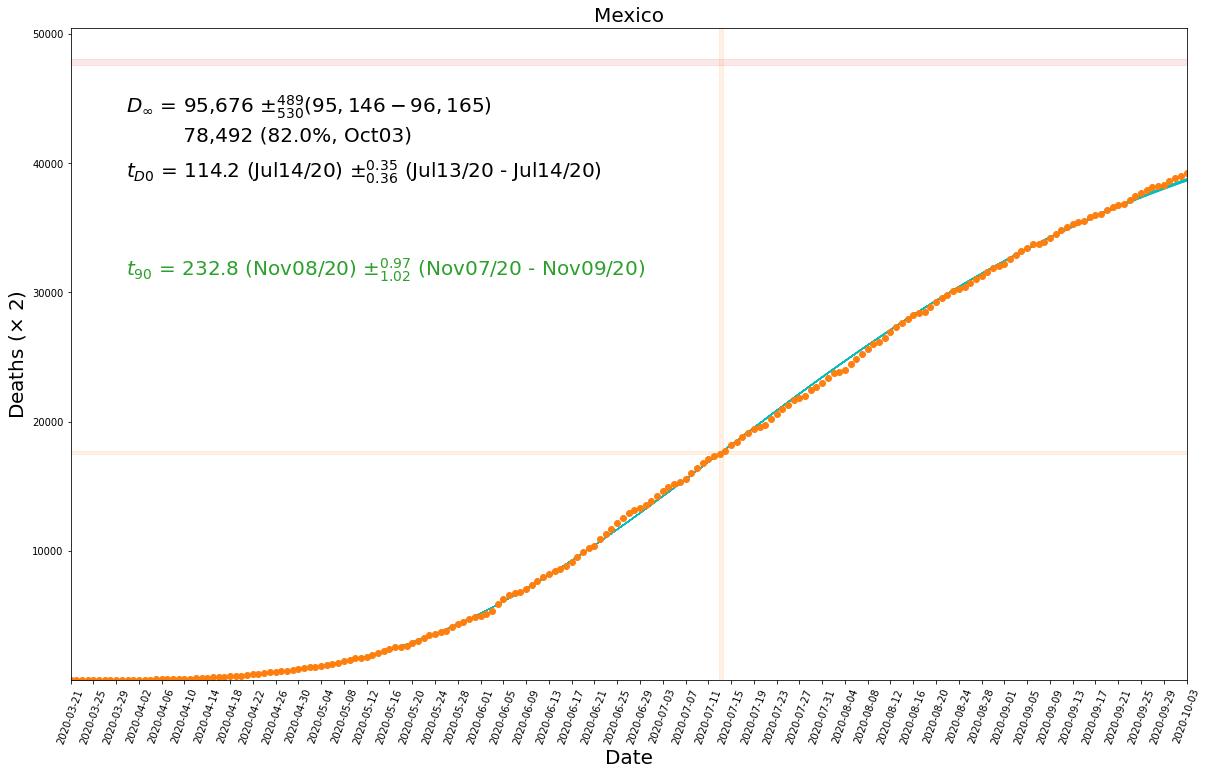

In [ ]:

fig, ax = plt.subplots(figsize=(20,12))
for i in range(500):
    index = np.random.randint(0,len(flat_samples)-1)
    model_= model(x2,flat_samples[index,1],flat_samples[index,2],flat_samples[index,3],flat_samples[index,4])
    ax.plot(x2,model_, 'c', linewidth=.5, alpha=0.2)
ax.plot(P_data['date'], ndead, 'C1o')

inflex = (date_info- timedelta(days=int(x[-1]-tdp))).strftime('%b%d/%y')
inflexmin = (date_info - timedelta(days=int(x[-1]-tdp+tdpmin))).strftime('%b%d/%y')
inflexmax = (date_info - timedelta(days=int(x[-1]-tdp-tdpmax))).strftime('%b%d/%y')

t90ex = (date_info + timedelta(days=int(tD90-x[-1]))).strftime('%b%d/%y')
t90exmin = (date_info + timedelta(days=int(tD90-tD90min-x[-1]))).strftime('%b%d/%y')
t90exmax = (date_info + timedelta(days=int(tD90+tD90max-x[-1]))).strftime('%b%d/%y')

#plt.yscale("log")
plt.title(country_choice,fontsize=20)
plt.xticks(rotation=70)
plt.xlabel('Date',fontsize=20)
plt.ylabel(r'Deaths ($\times$ %s)'%'{:,.0f}'.format(ndeaddefault[0]),fontsize=20)
plt.text(0.05, .90, r'$D_\infty$ = %s $\pm^{%s}_{%s} (%s -%s)$'
         %('{:,.0f}'.format(Dp),
           '{:,.0f}'.format(Dpmax),
           '{:,.0f}'.format(Dpmin),'{:,.0f}'.format(Dp-Dpmin),'{:,.0f}'.format(Dp+Dpmax)),
         ha='left', va='top',transform=ax.transAxes,fontsize=20)
plt.text(0.05, .85, '         %s (%s, %s) ' %('{:,.0f}'.format(ndeaddefault[0]*ndead[-1]),
                                      '{:,.1%}'.format(ndeaddefault[0]*ndead[-1]/Dp),date),
         ha='left', va='top', transform=ax.transAxes,fontsize=20)

plt.text(0.05, .8, r'$t_{D0}$ = %.1f (%s) $\pm^{%.2f}_{%.2f}$ (%s - %s)' %(tdp,inflex,tdpmax,tdpmin,inflexmin,inflexmax),ha='left', va='top',
    transform=ax.transAxes,fontsize=20)

plt.text(0.05, .65, r'$t_{90}$ = %.1f (%s) $\pm^{%.2f}_{%.2f}$ (%s - %s)' %(tD90,t90ex,tD90max,tD90min,t90exmin,t90exmax),ha='left', va='top',
    transform=ax.transAxes,fontsize=20,color='C2')


plt.axhspan(D-Dmin,D+Dmax, alpha=0.1,color='C3')
plt.axhspan(Dmed-Dmedmin,Dmed+Dmedmax, alpha=0.1,color='C1')
plt.axvspan(tdp-tdpmin,tdp+tdpmax,alpha=0.1, color='C1')
plt.xlim((0,x[-1]))
plt.ylim((1,None))
ax.set_xticks(ax.get_xticks()[::4])
#plt.yscale('log')

#Save the figure to disk
if save_plots == 'Yes':
    plt.savefig('plots/'+ country_choice+'B/'+ country_choice +'B_D_TD.pdf', dpi=150)

plt.show()

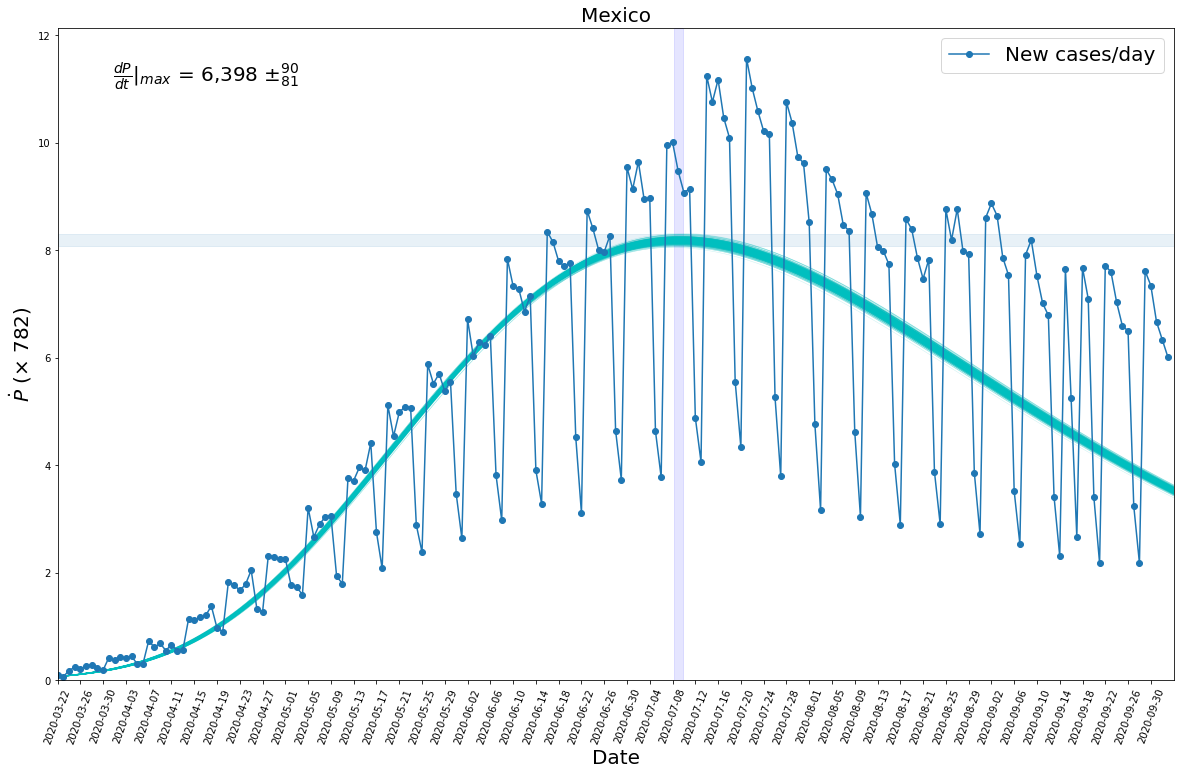

In [ ]:
fig, ax = plt.subplots(figsize=(20,12))

x2 = np.arange(0, 300)
for i in range(500):
    index = np.random.randint(0,len(flat_samples)-1)
    model_= modelDeriv(x2,flat_samples[index,0],0.,flat_samples[index,3],flat_samples[index,4])
    ax.plot(x2,model_, 'c', linewidth=.5, alpha=0.2)
ax.plot(P_data['date'][1:],np.diff(npos),'o-',label='New cases/day')
plt.legend(loc='upper right',fontsize=20)

plt.title(country_choice,fontsize=20)
plt.xticks(rotation=70)
plt.xlabel('Date',fontsize=20)
plt.ylabel(r'$\dot{P}$ ($\times$ %s)'%'{:,.0f}'.format(nposdefault[0]),fontsize=20)
plt.text(0.05, .95, r'$\left. \frac{dP}{dt} \right|_{max}$ = %s $\pm^{%s}_{%s}$'
         %('{:,.0f}'.format(PD*nposdefault[0]),
           '{:,.0f}'.format(PDmax*nposdefault[0]),
           '{:,.0f}'.format(PDmin*nposdefault[0])),
         ha='left', va='top',transform=ax.transAxes,fontsize=20)
plt.axhspan(PD-PDmin,PD+PDmax, alpha=0.1,color='C0')
plt.axvspan(tp-tpmin,tp+tpmax,alpha=0.1, color='b')
plt.xlim((0,x[-1]))
plt.ylim((0,None))
ax.set_xticks(ax.get_xticks()[::4])

#Save the figure to disk
if save_plots == 'Yes':
    plt.savefig('plots/'+ country_choice+'B/'+ country_choice +'B_PDeriv_TD.pdf', dpi=150)

plt.show()

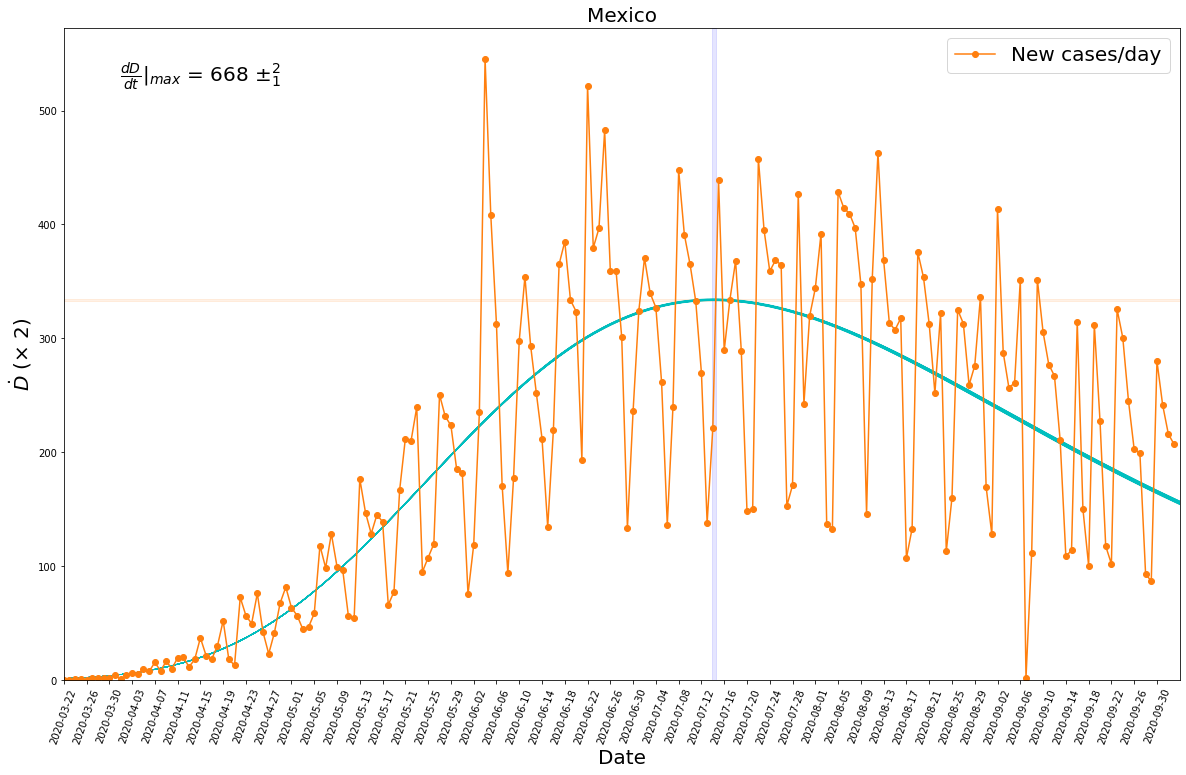

In [ ]:
fig, ax = plt.subplots(figsize=(20,12))
x2 = np.arange(0,300)
for i in range(500):
    index = np.random.randint(0,len(flat_samples)-1)
    model_= modelDeriv(x2,flat_samples[index,1],flat_samples[index,2],flat_samples[index,3],flat_samples[index,4])
    ax.plot(x2,model_, 'c', linewidth=.5, alpha=0.2)
ax.plot(P_data['date'][1:],np.diff(ndead),'C1o-',label='New cases/day')
plt.legend(loc='upper right',fontsize=20)

plt.title(country_choice,fontsize=20)
plt.xticks(rotation=70)
plt.xlabel('Date',fontsize=20)
plt.ylabel(r'$\dot{D}$ ($\times$ %s)'%'{:,.0f}'.format(ndeaddefault[0]),fontsize=20)
plt.text(0.05, .95, r'$\left. \frac{dD}{dt} \right|_{max}$ = %s $\pm^{%s}_{%s}$'
         %('{:,.0f}'.format(DD*ndeaddefault[0]),
           '{:,.0f}'.format(DDmax*ndeaddefault[0]),
           '{:,.0f}'.format(DDmin*ndeaddefault[0])),
         ha='left', va='top',transform=ax.transAxes,fontsize=20)

plt.axhspan(DD-DDmin,DD+DDmax, alpha=0.1,color='C1')
plt.axvspan(tdp-tdpmin,tdp+tdpmax,alpha=0.1, color='b')
plt.xlim((0,x[-1]))
plt.ylim((0,None))
ax.set_xticks(ax.get_xticks()[::4])

#Save the figure to disk
if save_plots == 'Yes':
    plt.savefig('plots/'+ country_choice+'B/'+ country_choice +'B_DDeriv_TD.pdf', dpi=150)

plt.show()

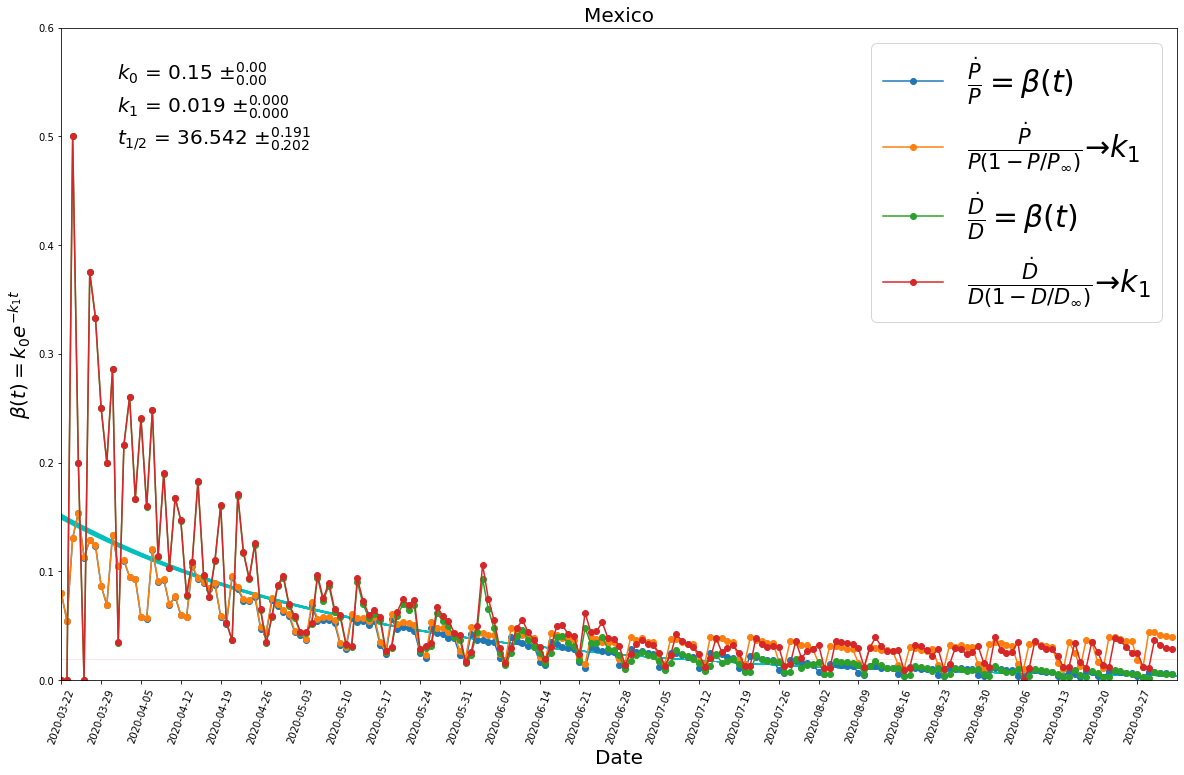

In [ ]:
fig, ax = plt.subplots(figsize=(20,12))

x2 = np.arange(0, 300)
for i in range(500):
    index = np.random.randint(0,len(flat_samples)-1)
    model_= modelbeta(x2,flat_samples[index,3],flat_samples[index,4])
    ax.plot(x2,model_, 'c', linewidth=.5, alpha=0.2)

x2N = np.arange(0, len(npos1))
ax.plot(P_data['date'][1:],nposdiff/npos1,'o-',label=r'$\frac{\dot{P}}{P} = \beta(t)$')
ax.plot(P_data['date'][1:],nposdiff/(npos1*(1.-npos1/(1.01*(P+Pmax)))),'o-',label=r'$\frac{\dot{P}}{P(1-P/P_\infty)} \to k_1$')
ax.plot(P_data['date'][1:],ndeaddiff/ndead1,'o-',label=r'$\frac{\dot{D}}{D} = \beta(t)$')
ax.plot(P_data['date'][1:],ndeaddiff/(ndead1*(1.-ndead1/(1.*(D+Dmax)))),'o-',label=r'$\frac{\dot{D}}{D(1-D/D_\infty)} \to k_1$')
plt.legend(loc='upper right',fontsize=30)

plt.title(country_choice,fontsize=20)
plt.xticks(rotation=70)
plt.xlabel('Date',fontsize=20)
plt.ylabel(r'$\beta(t) = k_0 e^{-k_1 t}$',fontsize=20)
plt.text(0.05, .95, r'$k_0$ = %s $\pm^{%s}_{%s}$'
         %('{:,.2f}'.format(k0p),
           '{:,.2f}'.format(k0pmax),
           '{:,.2f}'.format(k0pmin)),
         ha='left', va='top',transform=ax.transAxes,fontsize=20)
plt.text(0.05, .90, r'$k_1$ = %s $\pm^{%s}_{%s}$'
         %('{:,.3f}'.format(k1p),
           '{:,.3f}'.format(k1pmax),
           '{:,.3f}'.format(k1pmin)),
         ha='left', va='top',transform=ax.transAxes,fontsize=20)
plt.text(0.05, .85, r'$t_{1/2}$ = %s $\pm^{%s}_{%s}$'
         %('{:,.3f}'.format(tmed),
           '{:,.3f}'.format(tmedmax),
           '{:,.3f}'.format(tmedmin)),
         ha='left', va='top',transform=ax.transAxes,fontsize=20)

plt.axhspan(k1p-k1pmin,k1p+k1pmax,alpha=0.1,color='r')

plt.xlim((0,x[-1]))
plt.ylim((0,0.6))
ax.set_xticks(ax.get_xticks()[::7])

#Save the figure to disk
if save_plots == 'Yes':
    plt.savefig('plots/'+ country_choice+'B/'+ country_choice +'B_beta_TD.pdf', dpi=150)

plt.show()

In [ ]:
if save_plots == 'Yes':
    f1=open('plots/valuesB'+date+'.txt', "a+")

    f1.write(country_choice+' & $%s \pm^{%s}_{%s}$ & $%s \pm^{%s}_{%s}$ & $%s \pm^{%s}_{%s}$ & $%s \pm^{%s}_{%s}$ & $%s \pm^{%s}_{%s}$ \r\n'%
        ('{:,.0f}'.format(Pp),'{:,.0f}'.format(Ppmax),'{:,.0f}'.format(Ppmin),
         '{:,.0f}'.format(Dp),'{:,.0f}'.format(Dpmax),'{:,.0f}'.format(Dpmin),
         '{:,.2f}'.format(x0),'{:,.2f}'.format(x0max),'{:,.2f}'.format(x0min),
         '{:,.2f}'.format(k0p),'{:,.2f}'.format(k0pmax),'{:,.2f}'.format(k0pmin),
         '{:,.3f}'.format(k1p),'{:,.3f}'.format(k1pmax),'{:,.3f}'.format(k1pmin)
        ))

    f1.close()

    f2=open('plots/valuespB.txt', "a+")

    f2.write(country_choice+' & $%s \pm^{%s}_{%s}$ & $%s \pm^{%s}_{%s}$ & $%s \pm^{%s}_{%s}$ \r\n'%
        ('{:,.2f}'.format(tmed),'{:,.2f}'.format(tmedmax),'{:,.2f}'.format(tmedmin),
         '{:,.2f}'.format(tp),'{:,.2f}'.format(tpmax),'{:,.2f}'.format(tpmin),
         '{:,.2f}'.format(tdp),'{:,.2f}'.format(tdpmax),'{:,.2f}'.format(tdpmin)
        ))

    f2.close()